In [1]:
# Install required libraries
!pip install diffusers transformers accelerate bitsandbytes torch --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 113.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 98.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 107.1 MB/s eta 0:00:00


In [2]:
import torch
import time
from diffusers import StableDiffusionXLPipeline
from diffusers import FluxPipeline


In [3]:
def test_model(pipeline_cls, model_id, dtype):
    # Clear and reset GPU stats
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()

    # Load model
    t0 = time.perf_counter()
    pipe = pipeline_cls.from_pretrained(model_id, torch_dtype=dtype).to("cuda")
    load_time = time.perf_counter() - t0

    # Run inference
    t1 = time.perf_counter()
    result = pipe(prompt=positive_prompt, negative_prompt=negative_prompt)
    infer_time = time.perf_counter() - t1

    # Measure memory
    peak_alloc = torch.cuda.max_memory_allocated() / (1024**3)
    peak_res = torch.cuda.max_memory_reserved() / (1024**3)

    # Save output image
    img = result.images[0]
    img.save(f"{model_id.split('/')[-1]}_output.png")

    return {
        "load_time_s": round(load_time, 2),
        "infer_time_s": round(infer_time, 2),
        "peak_alloc_GB": round(peak_alloc, 2),
        "peak_reserved_GB": round(peak_res, 2)
    }

In [8]:
# Define prompts
positive_prompt = "A scenic landscape with rolling hills and a bright sunrise, Ghibli Style"
negative_prompt = "blurry, low resolution"

In [9]:
# Define model IDs
sdxl_id = "stabilityai/stable-diffusion-xl-base-1.0"
flux_id = "black-forest-labs/FLUX.1-schnell"

# Run tests
results = {
    "SDXL": test_model(StableDiffusionXLPipeline, sdxl_id, torch.float16),
    "Flux": test_model(FluxPipeline, flux_id, torch.bfloat16)
}

# Display results
import pandas as pd
df = pd.DataFrame(results).T
df

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

,load_time_s,infer_time_s,peak_alloc_GB,peak_reserved_GB
SDXL,76.45,5.87,10.47,14.09
Flux,92.06,14.42,33.81,36.06


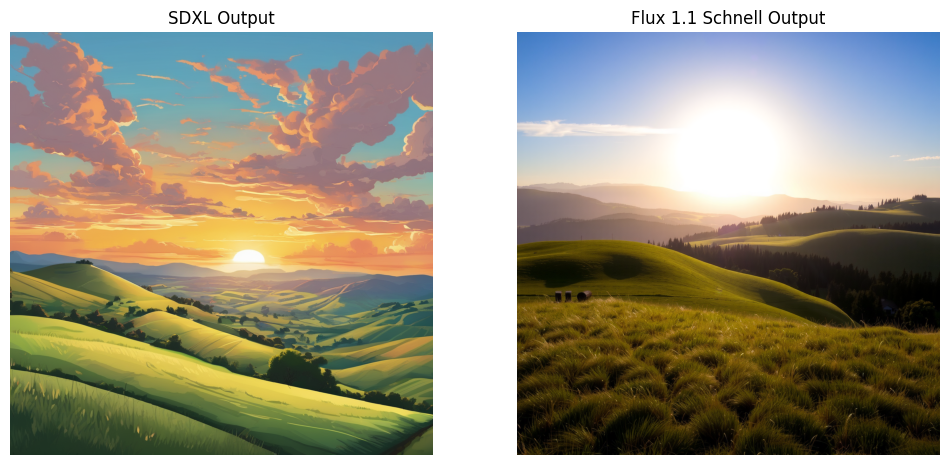

In [7]:
# Display generated images side by side
from PIL import Image
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(Image.open("sdxl-base_output.png"))
axs[0].set_title("SDXL Output")
axs[0].axis("off")

axs[1].imshow(Image.open("FLUX.1-schnell_output.png"))
axs[1].set_title("Flux 1.1 Schnell Output")
axs[1].axis("off")

plt.show()

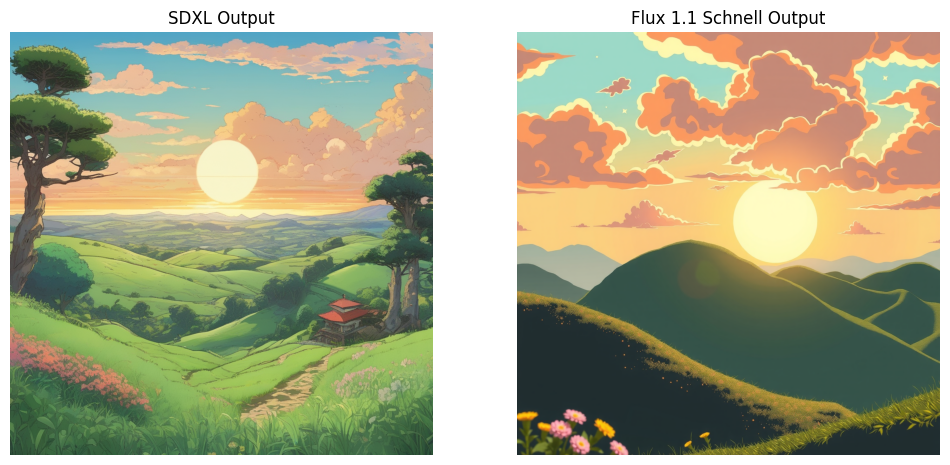

In [10]:
# Display generated images side by side - Ghibli Style
from PIL import Image
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(Image.open("sdxl-base_output.png"))
axs[0].set_title("SDXL Output")
axs[0].axis("off")

axs[1].imshow(Image.open("FLUX.1-schnell_output.png"))
axs[1].set_title("Flux 1.1 Schnell Output")
axs[1].axis("off")

plt.show()